### Imports

In [70]:
import os
# os.environ['PATH'] = '/usr/local/cuda-11.6/bin:' + os.environ['PATH']
if 'notebooks' not in os.listdir(os.getcwd()):
    os.chdir('../') #changing directories so that output/gsplat_full etc. exists

from contextlib import redirect_stdout
from video_api import initialize_gaussians
from gaussian_renderer import render
import sys 
import torch 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils.mujoco_utils import compute_camera_extrinsic_matrix, compute_camera_intrinsic_matrix
from utils.mujoco_utils import get_canonical_pose, set_xml_light_params, find_non_collision_pose, save_robot_metadata, ControlRobot
import mujoco
from utils.graphics_utils import getWorld2View2, getProjectionMatrix, se3_to_SE3
from IPython.display import Image as IPImage
from moviepy import ImageSequenceClip
from scipy.spatial.transform import Rotation 
import cv2
from torchviz import make_dot
import pandas as pd


### Functions

In [71]:
def display_render(image_tensor: torch.Tensor):
    im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
    im = (im * 255).astype(np.uint8)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

def pad_to_match_aspect(image, target_aspect_ratio):
    """
    Pads the input image (rendered image) to match the target aspect ratio.
    
    Args:
        image (torch.Tensor): Input image of shape [C, H, W].
        target_aspect_ratio (float): Target aspect ratio (width / height).

    Returns:
        torch.Tensor: Padded image with the target aspect ratio.
    """
    _, h, w = image.shape
    current_aspect_ratio = w / h

    if current_aspect_ratio < target_aspect_ratio:
        # Add padding to width
        new_width = int(h * target_aspect_ratio)
        pad = (new_width - w) // 2
        padding = (pad, pad, 0, 0)  # (left, right, top, bottom)
    else:
        # Add padding to height
        new_height = int(w / target_aspect_ratio)
        pad = (new_height - h) // 2
        padding = (0, 0, pad, pad)  # (left, right, top, bottom)
    
    return F.pad(image.unsqueeze(0), padding, mode='constant', value=0).squeeze(0)

def enforce_homogeneous_transform(matrix):
    """
    Ensures the matrix retains the properties of a homogeneous transformation.
    - The rotation part (3x3) is orthonormal.
    - The last row is [0, 0, 0, 1].
    """
    with torch.no_grad():
        # Extract the rotation part (3x3)
        rotation = matrix[:3, :3]
        
        # Re-orthogonalize using SVD
        u, _, v = torch.svd(rotation)
        rotation_orthogonal = torch.mm(u, v.t())
        
        # Update the matrix with the orthogonal rotation
        matrix[:3, :3] = rotation_orthogonal
        
        # Ensure the last row is [0, 0, 0, 1]
        matrix[:, 3] = torch.tensor([0, 0, 0, 1], device=matrix.device)
    
    return matrix

def enforce_homogeneous_transform_1(matrix):
    """
    Ensures the given 4x4 matrix is a valid homogeneous transformation matrix.
    - Rotation part is projected onto SO(3) (orthonormalized).
    - Bottom row is set to [0, 0, 0, 1].
    """
    # Extract rotation and translation components
    R = matrix[:3, :3]  # Rotation part
    t = matrix[:3, 3]   # Translation part

    # Orthonormalize rotation matrix via SVD
    U, _, Vt = torch.linalg.svd(R, full_matrices=False)  # SVD decomposition
    R_orthonormal = U @ Vt  # Reconstruct the rotation matrix

    # Ensure determinant is 1 (proper rotation matrix)
    if torch.det(R_orthonormal) < 0:
        R_orthonormal[:, -1] *= -1  # Fix improper rotation matrix

    # Reassemble the matrix
    T_homogeneous = torch.eye(4, device=matrix.device, dtype=matrix.dtype)
    T_homogeneous[:3, :3] = R_orthonormal.T  # Replace with orthonormalized rotation
    T_homogeneous[3, :3] = t               # Keep translation unchanged

    return T_homogeneous

def decompose_homogeneous_matrix(matrix):
    """
    Decomposes a homogeneous transformation matrix into Euler angles and translation.
    """
    rotation_matrix = matrix[:3, :3].T.cpu().numpy()
    translation = matrix[3, :3]
    
    # Convert rotation matrix to Euler angles
    euler_angles = torch.tensor(Rotation.from_matrix(rotation_matrix).as_euler('xyz', degrees=False), device=matrix.device)
    
    return euler_angles, translation

def assemble_homogeneous_matrix(euler_angles, translation):
    """
    Constructs a homogeneous transformation matrix from Euler angles and translation.
    """
    # Convert Euler angles to rotation matrix
    rotation_matrix = torch.tensor(Rotation.from_euler('xyz', euler_angles.detach().cpu().numpy(), degrees=False).as_matrix(), device=euler_angles.device)
    
    # Create a 4x4 homogeneous transformation matrix
    matrix = torch.eye(4, device=euler_angles.device)
    matrix[:3, :3] = rotation_matrix.T
    matrix[3, :3] = translation
    
    return matrix
def decompose_homogeneous_matrix_quaternion(matrix):
    """
    Decomposes a homogeneous transformation matrix into a quaternion and translation.
    """
    rotation_matrix = matrix[:3, :3].T
    translation = matrix[3, :3]
    
    # Convert rotation matrix to quaternion
    quaternion = torch.tensor(
        Rotation.from_matrix(rotation_matrix.cpu().numpy()).as_quat(), 
        device=matrix.device, dtype=torch.float32
    )
    
    return quaternion, translation

def quaternion_to_rotation_matrix(quaternion):
    """
    Convert a quaternion to a rotation matrix (differentiable).
    """
    q0, q1, q2, q3 = quaternion  # Assuming quaternion = [w, x, y, z]
    R = torch.stack([
        torch.tensor([1 - 2 * (q2 ** 2 + q3 ** 2), 2 * (q1 * q2 - q0 * q3), 2 * (q1 * q3 + q0 * q2)], device=quaternion.device),
        torch.tensor([2 * (q1 * q2 + q0 * q3), 1 - 2 * (q1 ** 2 + q3 ** 2), 2 * (q2 * q3 - q0 * q1)], device=quaternion.device),
        torch.tensor([2 * (q1 * q3 - q0 * q2), 2 * (q2 * q3 + q0 * q1), 1 - 2 * (q1 ** 2 + q2 ** 2)], device=quaternion.device)
    ])
    return R

def assemble_homogeneous_matrix_quaternion(quaternion, translation):
    """
    Constructs a homogeneous transformation matrix from a quaternion and translation.
    """
    # Convert quaternion to rotation matrix
    # rotation_matrix = torch.tensor(
    #     Rotation.from_quat(quaternion.detach().cpu().numpy()).as_matrix(), 
    #     device=quaternion.device, dtype=torch.float32
    # )
    rotation_matrix = quaternion_to_rotation_matrix(quaternion)
    # Create a 4x4 homogeneous transformation matrix
    matrix = torch.eye(4, device=quaternion.device)
    matrix[:3, :3] = rotation_matrix.T
    matrix[3, :3] = translation
    
    return matrix

def enforce_joint_limit(joint_pose):
    if joint_pose[2] > 0.47:
        joint_pose[2] = 0.47
    if joint_pose[4] > 0.42:
        joint_pose[2] = 0.42
    return joint_pose

def optimization(camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, euler_angles, translation, num_iterations=200):
    video = []
    losses = []
    for i in range(num_iterations):
        world_view_transform_result = assemble_homogeneous_matrix(euler_angles, translation)
        # Update the example_camera's parameters
        joint_pose_result = enforce_joint_limit(joint_pose_result)
        camera.joint_pose = joint_pose_result
        camera.world_view_transform = world_view_transform_result

        # Render the image with the current parameters
        rendered_image = torch.clamp(render(camera, gaussians, background_color)['render'], 0, 1)
        
        # padded_rendered_image = pad_to_match_aspect(rendered_image, target_aspect_ratio)

        # Compute the loss between the rendered image and the reference image
        loss = loss_fn(rendered_image, reference_image)
        losses.append(loss.item())

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the parameters
        optimizer.step()
        # world_view_transform_result = enforce_homogeneous_transform(world_view_transform_result)
        # Print progress
        if i % 10 == 0:
            print(f"Iteration {i}: Loss = {loss.item()}")
            # display_render(rendered_image)
            frame = rendered_image.detach().cpu()
            # frame = frame.numpy()
            
            # ## use cv2 to print the iteration number on the image
            # frame = cv2.putText(frame, f"Iteration {i}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # frame = render(example_camera, gaussians, background_color)['render'] #3, 480, 480
            video.append(frame)
    # plot_loss(losses)

    return video, joint_pose_result, assemble_homogeneous_matrix(euler_angles.detach(), translation.detach()), euler_angles, translation

def optimization_w2v(camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=200, plot=False):
    video = []
    losses = []
    stopping_count = 0
    # Compute the normalization factor based on the reference image
    normalization_factor = torch.sum(reference_image ** 2).item()  # Sum of squared pixel values
    normalized_threshold = 1e-6 * normalization_factor  # Scale the threshold based on the reference image
    previous_loss = None
    loss_change_threshold = 1e-6
    for i in range(num_iterations):
        # Update the example_camera's parameters
        camera.joint_pose = joint_pose_result
        camera.world_view_transform = world_view_transform_result

        # Render the image with the current parameters
        rendered_image = torch.clamp(render(camera, gaussians, background_color)['render'], 0, 1)

        # Compute the loss between the rendered image and the reference image
        loss = loss_fn(rendered_image, reference_image)

        losses.append(loss.item())

        # # Check the normalized stopping condition
        # if loss.item() < normalized_threshold:
        #     print(f"Stopping early at iteration {i} with loss {loss.item():.6f}, below threshold {normalized_threshold:.6f}")
        #     break

        # Check the loss change threshold
        if previous_loss is not None:
            loss_change = abs(previous_loss - loss.item())
            if loss_change < loss_change_threshold:
                stopping_count +=1
        if stopping_count > 3:
            print(f"Stopping early at iteration {i} with loss change {loss_change:.6f}, below threshold {loss_change_threshold:.6f}")
            break

        # Update previous loss for the next iteration
        previous_loss = loss.item()
        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the parameters
        optimizer.step()
        with torch.no_grad():
            world_view_transform_result.copy_(enforce_homogeneous_transform(world_view_transform_result))

        # Print progress
        if i % 10 == 0:
            # print(f"Iteration {i}: Loss = {loss.item():.6f}")
            video.append(rendered_image.detach().cpu())

    if plot:
        plot_loss(losses)

    # Return results
    return video, joint_pose_result, world_view_transform_result

def optimization_quat(camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quaternion, translation, num_iterations=200, plot=False):
    video = []
    losses = []
    for i in range(num_iterations):
        # Assemble the transformation matrix
        # world_view_transform_result = assemble_homogeneous_matrix_quaternion(quaternion, translation)

        # Update the example_camera's parameters
        camera.joint_pose = joint_pose_result
        camera.world_view_transform = world_view_transform_result

        # Render the image with the current parameters
        rendered_image = torch.clamp(render(camera, gaussians, background_color)['render'], 0, 1)

        # Compute the loss between the rendered image and the reference image
        loss = loss_fn(rendered_image, reference_image)

        losses.append(loss.item())

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()
        # print(quaternion)
        print("Gradients for joint", joint_pose_result.grad)
        print("Gradients for world_view_transform", world_view_transform_result.grad)
        print("Gradients for quaternion:", quaternion.grad)
        print("Gradients for translation:", translation.grad)
        # Update the parameters
        optimizer.step()

        # Normalize quaternion to maintain its properties
        with torch.no_grad():
            quaternion /= torch.norm(quaternion)

        # Print progress
        if i % 10 == 0:
            print(f"Iteration {i}: Loss = {loss.item()}")
            video.append(rendered_image.detach().cpu())
    # make_dot(loss, params={"quaternion": quaternion}).render("graph", format="png")
    if plot:
        plot_loss(losses)
    # Return results
    return video, joint_pose_result, assemble_homogeneous_matrix_quaternion(quaternion.detach(), translation.detach()), quaternion, translation

def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs. Iteration')
    plt.show()

# Function to count the number of files in a folder
def count_files(path):
    return len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])


def make_video(video, filename, fps=30):
    video = torch.stack(video)
    video = torch.clamp(video, 0, 1)
    video = video.cpu().detach().numpy()
    video = np.transpose(video, (0, 2, 3, 1))    
    video = (video * 255).astype(np.uint8)

    clip = ImageSequenceClip(list(video), fps=fps)
    clip.write_gif(f"{filename}.gif")


### Initialization

In [72]:
## ------ Initialize Gaussian Renderer ------ ##
sys.argv = ['']
gaussians, background_color, sample_cameras, kinematic_chain = initialize_gaussians(model_path='./output/p_short_exp_2', bg_color=[0, 0, 0])

# example_camera.image_height = 540
# example_camera.image_width = 960

Config file not found at
self.model_path ./output/p_short_exp_2
[Scene] Loading trained Gaussian model at iteration 60000
[Scene] Loading robot model from model path


/home/iulian/chole_ws/src/drrobot/scene/gaussian_model.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lrs = torch.load(os.path.join(os.path.dirname(path), 'lrs.pth'))

In [73]:
## ------ Configure Camera Parameters ------ ##
example_camera = sample_cameras[0]

## Customize camera parameters
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 0.1
cam.azimuth = -20.0
cam.elevation = -20
cam.lookat = (0,0,-0.4)
extrinsic = compute_camera_extrinsic_matrix(cam)
w2v = getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)
w2v_tensor = torch.tensor(getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)).transpose(0, 1).to(example_camera.data_device)
print(w2v)

## rotate the view
theta = -np.pi / 2  # 90 degrees in radians
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])

R = w2v[:3, :3]
t = w2v[:3, 3]

# Apply translation
t[1] = -0.5

# Apply the rotation
R_rotated = R_z @ R  # Rotate the original rotation matrix
t_rotated = R_z @ t  # Rotate the translation vector

# Combine back into a transformation matrix
T_rotated = np.eye(4)
T_rotated[:3, :3] = R_rotated
T_rotated[:3, 3] = t_rotated

T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)

example_camera.world_view_transform = T_rotated_torch
print(example_camera.world_view_transform)


[[-3.4202015e-01 -9.3969262e-01  2.9536866e-17  7.3842165e-18]
 [-3.2139382e-01  1.1697778e-01 -9.3969262e-01 -3.7587705e-01]
 [ 8.8302225e-01 -3.2139382e-01 -3.4202015e-01 -3.6808059e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -8.7076e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.8000e-17, -3.6808e-02,  1.0000e+00]])


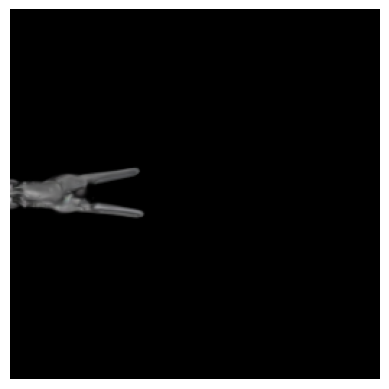

w2v: tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -8.7076e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.8000e-17, -3.6808e-02,  1.0000e+00]],
       requires_grad=True)
Sum of joint gradients: tensor(1192.3115)
Sum of camera gradients: tensor(21866.1250)


In [74]:
## ------ Render Init Gaussian ------ ##
n = len(kinematic_chain.get_joint_parameter_names())    
home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
example_camera.joint_pose = torch.tensor(home_pose,).requires_grad_(True)
example_camera.world_view_transform.requires_grad_(True)
result = render(example_camera, gaussians, background_color)

# Use the raw alpha channel as a continuous mask
mask = result['render']  # Continuous alpha values, directly from render_alphas
frame = mask  # Use the mask directly without clamping or thresholding

# Display the mask (optional, normalized for visualization)
display_render(torch.clamp(mask, 0, 1))

print("w2v:", example_camera.world_view_transform)
frame.sum().backward()
print('Sum of joint gradients:', example_camera.joint_pose.grad.sum())
print('Sum of camera gradients:', example_camera.world_view_transform.grad.sum())

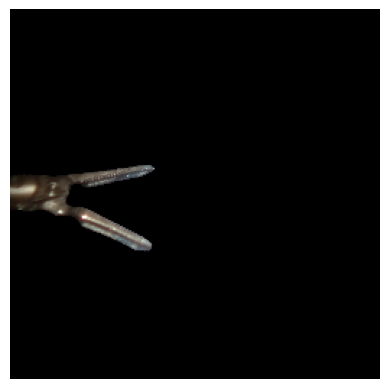

Reference image shape: torch.Size([3, 256, 256])
844.3558959960938


In [75]:
## ------ Display Reference Image ------ ##
original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/000000.jpg"  # Path to your reference image
reference_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_80/grab/000000.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/mask_2.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/segmented_tool_8_0.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_77/1_grabbing_gallbladder/20240907-090634-569257/left_img_dir/frame000017_left.jpg"  # Path to your reference image

## read the image
original_image = Image.open(original_image_path).convert('RGB')
reference_image = Image.open(reference_image_path).convert('RGB')

## crop the image to be square
# reference_image = np.array(reference_image)[:540, :540]
reference_image = torch.tensor(np.array(reference_image) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
reference_image = pad_to_match_aspect(reference_image, 1.0)

reference_image = F.interpolate(reference_image.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)

plt.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
print("Reference image shape:", reference_image.shape)  # Expected: [3, H, W]

# Calculate target aspect ratio (reference image)
target_aspect_ratio = reference_image.shape[2] / reference_image.shape[1]

# Pad the rendered image to match the aspect ratio of the reference image
normalization_factor = torch.sum(reference_image ** 2).item()  # Sum of squared pixel values
print(normalization_factor)

### Optimization

In [76]:
## ------ Setting Optimization Parameters ------ ##

# Initialize parameters
joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")  # Initial joint pose
world_view_transform_result = example_camera.world_view_transform.clone().detach().to("cuda").requires_grad_(True) # Initial camera transform
print(joint_pose_result)
print(world_view_transform_result)
# Define different learning rates
# joint_pose_lr = 2e-4
# world_transform_lr = 1e-4

joint_pose_lr = 1e-3
rotation_lr = 1e-4
translation_lr = 1e-4
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# quat, translation = decompose_homogeneous_matrix_quaternion(example_camera.world_view_transform.clone().detach().cpu())
# quat = torch.nn.Parameter(quat, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": quat, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
num_iterations = 500

loss_fn = torch.nn.MSELoss()
video = []


tensor([ 0.0000,  0.1250,  0.2220, -0.2030,  0.2570], device='cuda:0',
       requires_grad=True)
tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -8.7076e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.8000e-17, -3.6808e-02,  1.0000e+00]], device='cuda:0',
       requires_grad=True)


Stopping early at iteration 57 with loss change 0.000000, below threshold 0.000001


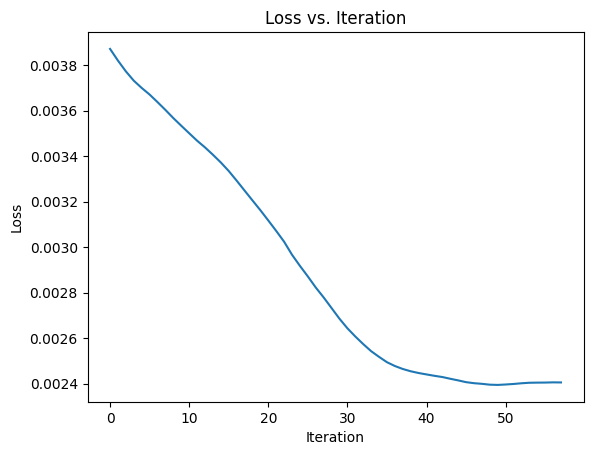

Final joint pose: tensor([-0.0449,  0.1715,  0.1735, -0.1877,  0.2726], device='cuda:0',
       requires_grad=True)
Final camera transform: tensor([[-3.1715e-01,  3.4430e-01,  8.8367e-01,  0.0000e+00],
        [ 1.1550e-01,  9.3886e-01, -3.2435e-01,  0.0000e+00],
        [-9.4132e-01, -8.0591e-04, -3.3752e-01,  0.0000e+00],
        [-5.0324e-01, -1.3029e-03, -3.9195e-02,  1.0000e+00]], device='cuda:0',
       requires_grad=True)


In [77]:

# Optimization loop
video, joint_pose_result, world_view_transform_result= optimization_w2v(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations, plot=True)
# video, joint_pose_result, world_view_transform_result, euler_angles_result, translation_result = optimization_quat(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)

# Final results
print("Final joint pose:", joint_pose_result)
print("Final camera transform:", world_view_transform_result)


MoviePy - Building file pose_est_init.gif with imageio.


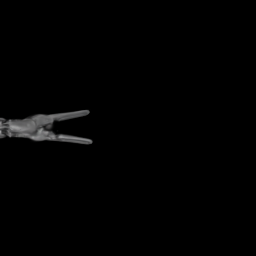

In [78]:
## ------ Save the video ------ ##
make_video(video, filename="pose_est_init", fps=10)
IPImage(filename="pose_est_init.gif")


(-0.5, 255.5, 255.5, -0.5)

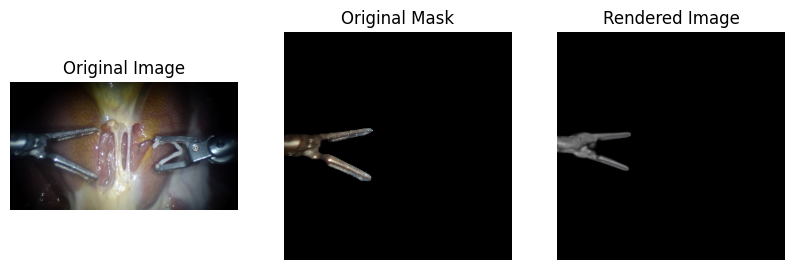

In [79]:
## ------ Compare the final rendered image and the reference image------ ##

final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)

# display_render(final_render)
padded_rendered_image = pad_to_match_aspect(final_render, target_aspect_ratio)
## subplot to show the original image and the rendered image
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original Image")
ax.imshow(original_image)
ax.axis('off')

ax = plt.subplot(1, 3, 2)
ax.set_title("Original Mask")
ax.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
ax.axis('off')

subplot = plt.subplot(1, 3, 3)
subplot.set_title("Rendered Image")
subplot.imshow(final_render.detach().permute(1, 2, 0).cpu().numpy())
subplot.axis('off')


Number of images: 88
MoviePy - Building file mask_test.gif with imageio.


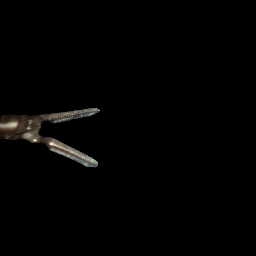

In [80]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/data/tissue_75/segment_results/"

# Count the number of files and prepare the image list
imgs = []
image_num = count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"frame_{i}_id_1.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]

    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = pad_to_match_aspect(img, 1.0)
    
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

make_video(imgs, filename="mask_test")

IPImage(filename="mask_test.gif")

In [81]:


def optimize_and_tune(
    example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
    world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=30,
    max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
):
    """
    Iteratively tunes num_iterations and learning rates to minimize errors.
    
    Args:
        example_camera: Camera object for rendering.
        gaussians: Gaussian object for rendering.
        background_color: Background color for rendering.
        imgs: List of reference images for optimization.
        loss_fn: Loss function.
        joint_pose_result: Initial joint pose parameter.
        world_view_transform_result: Initial world view transform parameter.
        ee_l_qpos: Ground truth trajectory (numpy array).
        initial_lr: Initial learning rate.
        initial_iterations: Initial number of iterations.
        max_epochs: Maximum number of tuning epochs.
        error_threshold: Error threshold for stopping.
        decay_factor: Factor to decay learning rate and iterations.
        lr_min: Minimum learning rate.

    Returns:
        Tuple of tuned parameters, errors, and final visualization.
    """
    best_errors = None
    best_config = None
    current_lr = initial_lr
    current_iterations = initial_iterations

    for epoch in range(max_epochs):
        print(f"Epoch {epoch + 1}/{max_epochs}")
        optimizer = torch.optim.Adam([
            {"params": joint_pose_result, "lr": current_lr},
            {"params": world_view_transform_result, "lr": current_lr}
        ])

        joint_pose_results = []
        world_view_transform_results = []
        results = []

        for img in imgs:
            video, joint_pose_result, world_view_transform_result = optimization_w2v(
                example_camera, gaussians, background_color, img, loss_fn, optimizer,
                joint_pose_result, world_view_transform_result, num_iterations=current_iterations
            )
            joint_pose_results.append(joint_pose_result.clone().detach())
            world_view_transform_results.append(world_view_transform_result.clone().detach())

        trans_init = world_view_transform_results[0][3, :3].detach().cpu().numpy()
        for r in world_view_transform_results:
            res = r[3, :3].detach().cpu().numpy()
            res = trans_init - res
            results.append(res)

        # Compute errors
        errors = []
        for i in range(len(ee_l_qpos)):
            error = np.linalg.norm(ee_l_qpos[i, :3] - results[i][:3])
            errors.append(error)
        
        mean_error = np.mean(errors)
        print(f"Mean error: {mean_error}")

        # Update best configuration if errors improve
        if best_errors is None or mean_error < np.mean(best_errors):
            best_errors = errors
            best_config = (current_lr, current_iterations)

        # Adjust learning rates and iterations if error is not improving significantly
        if mean_error < error_threshold:
            print("Error threshold reached. Stopping optimization.")
            break
        elif epoch > 0 and mean_error >= np.mean(best_errors):
            current_lr = max(current_lr * decay_factor, lr_min)
            current_iterations = int(current_iterations * (1 + decay_factor))
            print(f"Adjusting learning rate to {current_lr} and iterations to {current_iterations}.")

    # Final visualization
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for res in results:
        ax.scatter(res[0], res[1], res[2], c="b")
    ax.scatter(ee_l_qpos[:, 0], ee_l_qpos[:, 1], ee_l_qpos[:, 2], c="r")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(-90, 90)
    plt.title("Relative action trajectory")
    plt.show()

    plt.plot(best_errors, label="Best Errors")
    plt.xlabel("Frame")
    plt.ylabel("Error")
    plt.title("Error between the estimated and the ground truth")
    plt.legend()
    plt.show()

    return best_config, best_errors


In [82]:

# ## read the csv file
# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/ee_csv.csv"
# ee_csv = pd.read_csv(ee_csv_path)
# header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
#                         "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
#                         "psm1_jaw"]

# header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
#                         "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
#                         "psm2_jaw"]

# ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
# ee_l_qpos_init = ee_l_qpos[0]
# ## normalize the data (substract with the initial pose)
# ee_l_qpos = ee_l_qpos - ee_l_qpos_init

# best_config, best_errors = optimize_and_tune(
#     example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
#     world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=10,
#     max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
# )

In [83]:
# best_config

In [84]:
# Initialize parameters
joint_pose_results = []
world_view_transform_results = []
videos = []
euler_results = []
trans_results = []

# Optimization loop
num_iterations = 10
# Define different learning rates
# joint_pose_lr = 5e-4
# rotation_lr = 1
# translation_lr = 3e-5

joint_pose_lr = 8e-4
translation_lr = 5e-5
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
# euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": euler_angles, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
for img in imgs:
    ## call the optimization function
    video, joint_pose_result, world_view_transform_result= optimization_w2v(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, euler_result, trans_result = optimization_quat(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)
    
    joint_pose_results.append(joint_pose_result.clone().detach())
    world_view_transform_results.append(world_view_transform_result.clone().detach())
    # euler_results.append(euler_result.clone().detach())
    # trans_results.append(trans_result.clone().detach())
    videos.append(video[-1])    # append the last frame of the video

# # Final results
# print("Final joint pose:", joint_pose_result)
# print("Final camera transform:", world_view_transform_result)


Stopping early at iteration 5 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 5 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 8 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 4 with loss change 0.000001, below threshold 0.000001
Stopping early at iteration 4 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 6 with loss change 0.000001, below threshold 0.000001
Stopping early at iteration 5 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 6 with loss change 0.000001, below threshold 0.000001
Stopping early at iteration 7 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 8 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 7 with loss change 0.000000, below threshold 0.000001
Stopping early at iteration 9 with loss change 0.000001, below threshold 0.000001
Stopping early a

MoviePy - Building file tracking_sequence_test.gif with imageio.


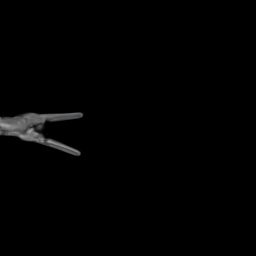

In [85]:
## ------ Save the video ------ ##
make_video(videos, "tracking_sequence_test")
IPImage(filename="tracking_sequence_test.gif")


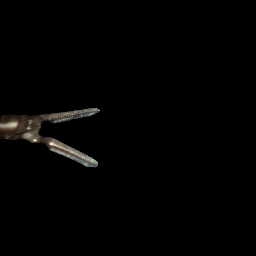

In [86]:
IPImage(filename="mask_test.gif")


In [87]:
trans_results = []
for w in world_view_transform_results:
    trans_results.append(w[3, :3].clone())
# trans_results = world_view_transform_results[:][:3, 3]

In [88]:
## plot the translation results
## 3D plot




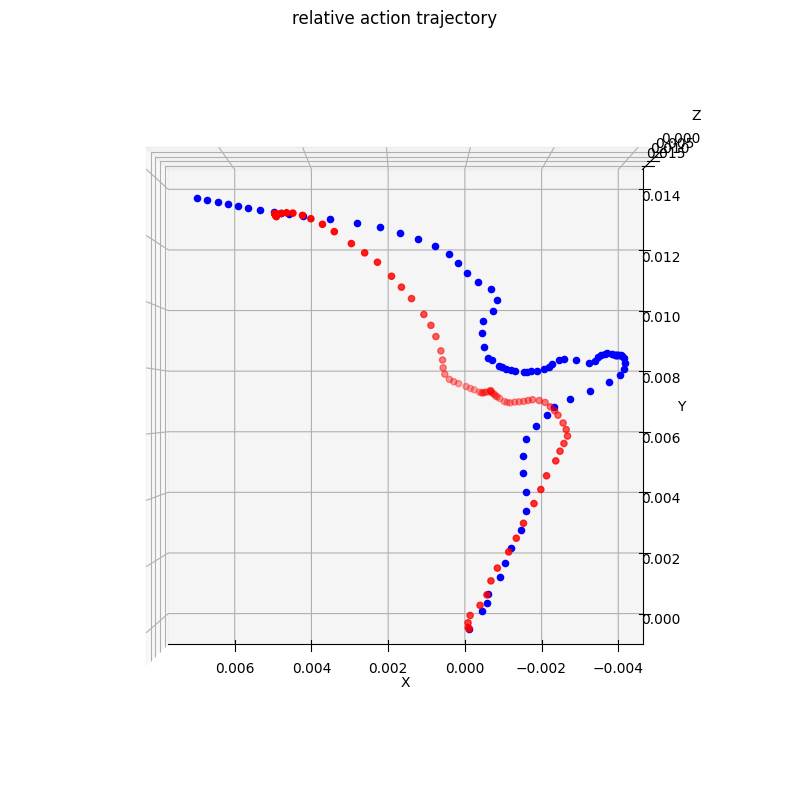

In [104]:
## read the csv file
ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/ee_csv.csv"
ee_csv = pd.read_csv(ee_csv_path)
header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
                        "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
                        "psm1_jaw"]

header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
                        "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
                        "psm2_jaw"]

ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
ee_l_qpos_init = ee_l_qpos[0]
## normalize the data (substract with the initial pose)
ee_l_qpos = ee_l_qpos - ee_l_qpos_init
results = []
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

trans_init = trans_results[6].detach().cpu().numpy()
count = 0
for r in trans_results:
    res = r.detach().cpu().numpy()
    res = trans_init - res
    results.append([res[0], res[1], -res[2]])
    if count >= 6:
        ax.scatter(res[0], res[1], -res[2], c="b")
    count += 1
    # if count>50: 
        # break
# # plt.show()
# ax = fig.add_subplot(121, projection='3d')
ax.scatter(ee_l_qpos[:, 0], ee_l_qpos[:, 1], ee_l_qpos[:, 2], c="r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
## look from the top
ax.view_init(-90, 90)
## set title
plt.title("relative action trajectory")
# ax.legend(["robot", "human"])
plt.show()

[0.00000000e+00 4.96535611e-05 1.90143930e-04 4.17760882e-04
 7.77528368e-04 1.13988258e-03 1.57632971e-03 1.99954572e-03
 2.56068566e-03 3.01890830e-03 3.50931352e-03 4.16397269e-03
 4.62466280e-03 5.06669132e-03 5.57341042e-03 5.88806149e-03
 6.14356544e-03 6.38933844e-03 6.56542798e-03 6.72899204e-03
 6.91737081e-03 7.02511598e-03 7.11053703e-03 7.20829460e-03
 7.23183057e-03 7.21989027e-03 7.17457085e-03 7.12576063e-03
 7.09223509e-03 7.06460233e-03 7.02581977e-03 7.03022675e-03
 7.04672497e-03 7.12751456e-03 7.16798719e-03 7.19144361e-03
 7.23205091e-03 7.26375888e-03 7.28654613e-03 7.31356325e-03
 7.34130320e-03 7.35471599e-03 7.34704689e-03 7.30240626e-03
 7.29114072e-03 7.28673913e-03 7.26445255e-03 7.26727270e-03
 7.29237641e-03 7.35813349e-03 7.40087259e-03 7.45944594e-03
 7.55470330e-03 7.61721188e-03 7.69498250e-03 7.86195290e-03
 8.06225807e-03 8.30263952e-03 8.58621594e-03 9.03176857e-03
 9.38405317e-03 9.73214288e-03 1.02447341e-02 1.06219075e-02
 1.09851489e-02 1.145986

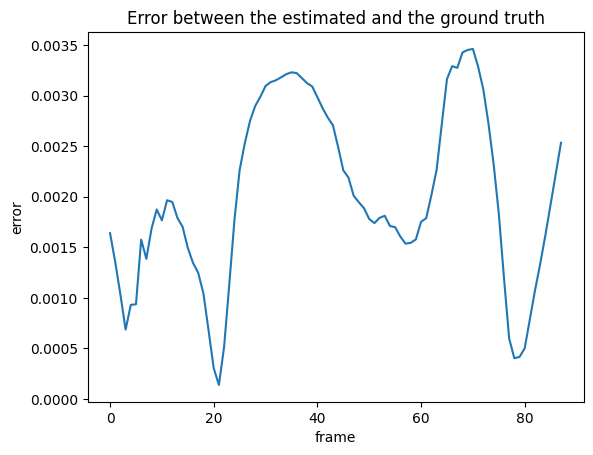

In [102]:
## plot error between the estimation and the ground truth
errors = []

n = 2
for i in range(len(ee_l_qpos)):
    error = np.linalg.norm(ee_l_qpos[i, :n] - results[i][:n])

    errors.append(error)

print(np.linalg.norm(ee_l_qpos[:, :n], axis=1))
plt.plot(errors)
# plt.plot(np.linalg.norm(ee_l_qpos[:, :n], axis=1), 'r')
plt.xlabel("frame")
plt.ylabel("error")
plt.title("Error between the estimated and the ground truth")
plt.show()

